In [1]:
!nvidia-smi

Sun Jan 14 20:55:50 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.129.03             Driver Version: 535.129.03   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
import tensorflow as tf

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
physical_devices = tf.config.list_physical_devices('GPU')
physical_devices

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]

In [4]:
# enable memory growth
for pd in physical_devices:
    tf.config.experimental.set_memory_growth(pd,enable = True)

In [5]:
import tensorflow as tf
import matplotlib.pyplot as plt
import time

In [6]:
strategy = tf.distribute.MultiWorkerMirroredStrategy(
    cluster_resolver=None, communication_options=None
)
print('Number of devices: {}'.format(strategy.num_replicas_in_sync))

Number of devices: 2


In [7]:
policy = tf.keras.mixed_precision.Policy('mixed_float16')
tf.keras.mixed_precision.set_global_policy(policy)

<!-- TOC --><a name="import-libraries"></a>
# Import libraries

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
import warnings

warnings.filterwarnings('ignore')

<!-- TOC --><a name="data-analysis"></a>
# Data analysis

In [9]:
# Define data paths

test_dir = "/kaggle/input/new-parkinson-pd/test"
train_dir = "/kaggle/input/new-parkinson-pd/train"

In [10]:
# Check size of each dataset

import os

def get_dataset_size(dir, type):
    print(f"Scanning {type} images...")
    size = 0
    for label in os.listdir(dir):
        size += len(os.listdir(os.path.join(dir, label)))
    print(f"Number of {type} images: {size}\n")
    return size

num_test = get_dataset_size(test_dir, "test")
num_train = get_dataset_size(train_dir, "train")

Scanning test images...
Number of test images: 66

Scanning train images...
Number of train images: 244



In [11]:
num_classes = len(os.listdir(train_dir))
print(f"Number of classes: {num_classes}")

Number of classes: 2


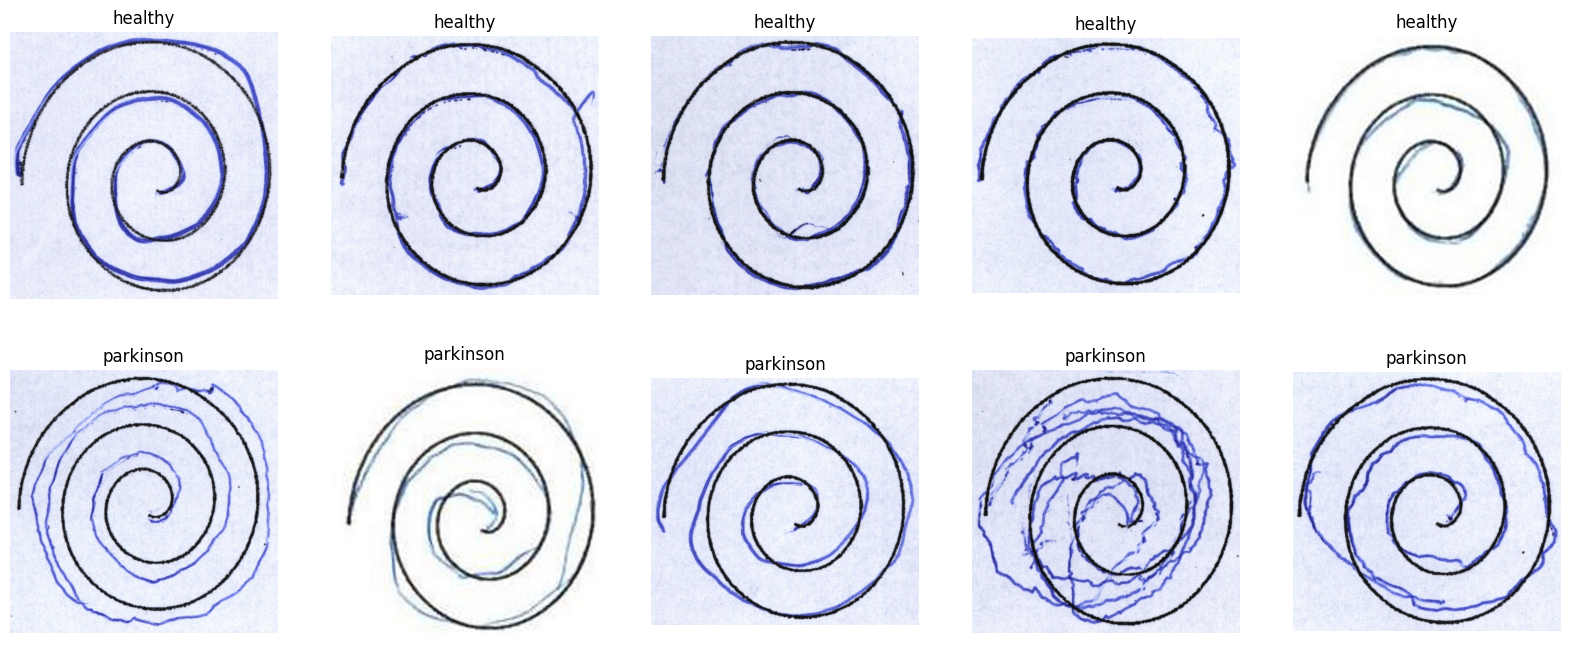

In [12]:
# Let's view a few training samples

import random
import cv2

# imgs to plot per class
m = 5

fig, axs = plt.subplots(nrows=num_classes, ncols=m, figsize=(m*4, num_classes*4))

for i in range(num_classes):

    label = os.listdir(train_dir)[i]
    
    for j in range(m):
        
        # get a random image from the chosen species
        
        img_name = random.choice(os.listdir(os.path.join(train_dir, label)))
        img_path = os.path.join(train_dir, label, img_name)
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # plot the image
        axs[i][j].imshow(image)
        axs[i][j].set_title(label)
        axs[i][j].axis("off")
        
fig.show()

<!-- TOC --><a name="create-image-data-generators"></a>
# Create image data generators

In [13]:
# Let's create our image preprocessors

from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    horizontal_flip=True,
)

test_datagen = ImageDataGenerator(
    validation_split=0.2
)

In [14]:
# Let's define the target size

input_size = (224, 224)

In [15]:
# Let's create our image generators

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=input_size,
    batch_size=32,
    shuffle=True,
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=input_size,
    batch_size=32,
    shuffle=False,
    subset = 'validation'
)

val_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=input_size,
    batch_size=32,
    shuffle=True,
    subset = 'training'
)

Found 244 images belonging to 2 classes.
Found 12 images belonging to 2 classes.
Found 54 images belonging to 2 classes.


<!-- TOC --><a name="set-up-the-model"></a>
# Set up the model

<!-- TOC --><a name="load-pretrained-model"></a>
## Load pretrained model

Let's load a Resnet152 model which has been pretrained on the ImageNet dataset

In [16]:
import ssl

ssl._create_default_https_context = ssl._create_unverified_context


In [17]:
from tensorflow.keras.applications.resnet import ResNet152, preprocess_input

In [18]:
# Load the pre-trained ResNet-50 model (excluding the top layer)
base_model = ResNet152(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

234698864/234698864 [==============================] - 1s 0us/step


In [19]:
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import GlobalAveragePooling2D

In [20]:
# Now let's combine all the layers into a complete model
def build_model():
    base_model = ResNet152(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    
    image_batch, label_batch = next(iter(train_generator))
    feature_batch = base_model(image_batch)
    
    base_model.trainable = False
    
    global_average_layer = GlobalAveragePooling2D()
    feature_batch_average = global_average_layer(feature_batch)
    
    prediction_layer = Dense(num_classes)
    prediction_layer_output = prediction_layer(feature_batch_average)

    inputs = tf.keras.Input(shape=input_size + (3,))
    x = preprocess_input(inputs)
    x = base_model(x)
    x = global_average_layer(x)
    outputs = prediction_layer(x)

    model = tf.keras.Model(inputs, outputs)
    
    base_learning_rate = 0.0001

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
        loss="binary_crossentropy",
        metrics=["accuracy"]
    )
    
    return model

In [21]:
# buiding a model inside the strategy scope
with strategy.scope():
    multi_gpu_model_res = build_model()
    
multi_gpu_model_res.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.__operators__.getitem (S  (None, 224, 224, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 224, 224, 3)      0         
                                                                 
 resnet152 (Functional)      (None, 7, 7, 2048)        58370944  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 2)                 4098  

In [22]:
len(multi_gpu_model_res.trainable_variables)

2

In [23]:
initial_epochs = 500

In [24]:
loss0, accuracy0 = multi_gpu_model_res.evaluate(test_generator)

print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

1/1 [==============================] - 18s 18s/step - loss: 4.1938 - accuracy: 0.5833
initial loss: 4.19
initial accuracy: 0.58


In [25]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10)

In [26]:
# Let's fit the model
# Remember, we are only training the classification head

history = multi_gpu_model_res.fit(
    train_generator,
    epochs=initial_epochs,
    validation_data=val_generator,
    callbacks = [callback]
)

Epoch 1/500
8/8 [==============================] - 33s 610ms/step - loss: 4.5223 - accuracy: 0.5615 - val_loss: 3.7915 - val_accuracy: 0.6481
Epoch 2/500
8/8 [==============================] - 3s 368ms/step - loss: 4.3350 - accuracy: 0.5451 - val_loss: 3.8012 - val_accuracy: 0.6481
Epoch 3/500
8/8 [==============================] - 3s 363ms/step - loss: 4.3126 - accuracy: 0.5451 - val_loss: 3.7553 - val_accuracy: 0.6481
Epoch 4/500
8/8 [==============================] - 3s 377ms/step - loss: 4.2881 - accuracy: 0.5410 - val_loss: 3.3822 - val_accuracy: 0.6296
Epoch 5/500
8/8 [==============================] - 3s 350ms/step - loss: 4.2532 - accuracy: 0.5369 - val_loss: 3.3975 - val_accuracy: 0.6481
Epoch 6/500
8/8 [==============================] - 3s 365ms/step - loss: 4.0951 - accuracy: 0.5451 - val_loss: 3.7646 - val_accuracy: 0.6481
Epoch 7/500
8/8 [==============================] - 3s 352ms/step - loss: 4.1270 - accuracy: 0.5451 - val_loss: 3.7480 - val_accuracy: 0.6481
Epoch 8/500


In [27]:
loss, acc = multi_gpu_model_res.evaluate(test_generator, verbose=False)
print(f"Test Accuracy: {acc*100}%")
print(f"Test Loss: {loss*100}")

Test Accuracy: 75.0%
Test Loss: 326.5594482421875


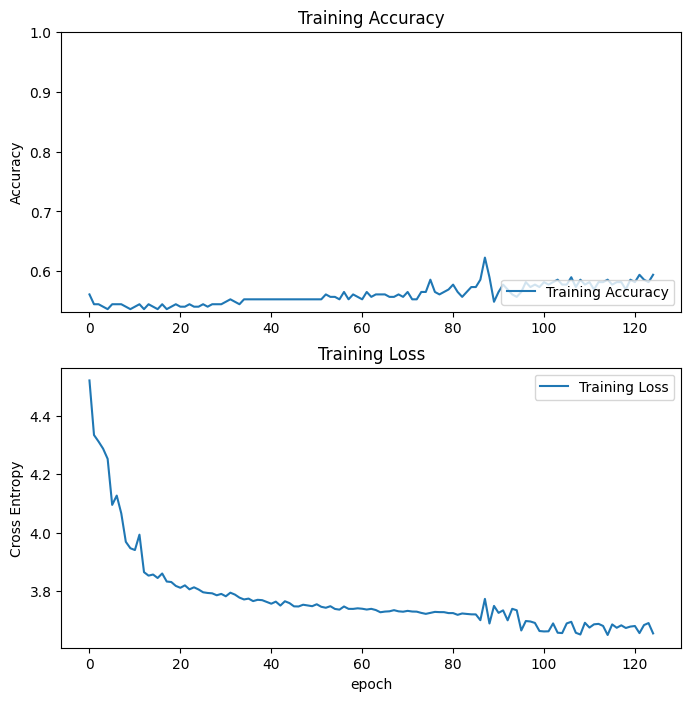

In [28]:
# Let's plot the results of the training

acc = history.history['accuracy']

loss = history.history['loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title('Training Loss')
plt.xlabel('epoch')

plt.savefig("Accuracy and Loss Curves without finetuning")
plt.show()

In [29]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

Number of layers in the base model:  515


In [30]:
# Now let's combine all the layers into a complete model
def build_model_2():
    base_model = ResNet152(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    
    base_model.trainable = True
    
    image_batch, label_batch = next(iter(train_generator))
    feature_batch = base_model(image_batch)
    
    global_average_layer = GlobalAveragePooling2D()
    feature_batch_average = global_average_layer(feature_batch)
    
    prediction_layer = Dense(num_classes)
    prediction_layer_output = prediction_layer(feature_batch_average)

    inputs = tf.keras.Input(shape=input_size + (3,))
    x = preprocess_input(inputs)
    x = base_model(x)
    x = global_average_layer(x)
    outputs = prediction_layer(x)

    model = tf.keras.Model(inputs, outputs)
    
    base_learning_rate = 0.0001
    
    
    # Fine-tune from this layer onwards
    fine_tune_at = 18

    # Freeze all the layers before the `fine_tune_at` layer
    for layer in base_model.layers[:fine_tune_at]:
        layer.trainable = False

#     for layer in base_model.layers:
#         if 'pool' in layer.name:
#             layer.trainable = False
#         else:
#             layer.trainable = True
        
    model.compile(
        loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
        optimizer = tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
        metrics=['accuracy']
    )
    
    return model

In [31]:
multi_gpu_model_res_2 = build_model_2()

In [32]:
multi_gpu_model_res_2.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.__operators__.getitem_1   (None, 224, 224, 3)      0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_1 (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 resnet152 (Functional)      (None, 7, 7, 2048)        58370944  
                                                                 
 global_average_pooling2d_1   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                           

In [33]:
len(multi_gpu_model_res_2.trainable_variables)

602

In [34]:
earlystopping = tf.keras.callbacks.EarlyStopping(
    monitor="loss", 
    patience=10, 
    restore_best_weights=True
)

In [35]:
# Let's fine tune the model
fine_tune_epochs = 468
total_epochs =  40 + fine_tune_epochs

history_fine = multi_gpu_model_res_2.fit(
    train_generator,
    epochs=total_epochs,
    initial_epoch=history.epoch[-1],
    validation_data = val_generator,
    callbacks=[earlystopping]
)

Epoch 125/508
8/8 [==============================] - 127s 1s/step - loss: 0.3878 - accuracy: 0.8484 - val_loss: 0.8588 - val_accuracy: 0.4259
Epoch 126/508
8/8 [==============================] - 4s 474ms/step - loss: 0.1113 - accuracy: 0.9631 - val_loss: 1.1060 - val_accuracy: 0.4444
Epoch 127/508
8/8 [==============================] - 4s 443ms/step - loss: 0.1130 - accuracy: 0.9631 - val_loss: 1.1277 - val_accuracy: 0.5185
Epoch 128/508
8/8 [==============================] - 4s 490ms/step - loss: 0.0991 - accuracy: 0.9549 - val_loss: 0.4268 - val_accuracy: 0.8333
Epoch 129/508
8/8 [==============================] - 4s 472ms/step - loss: 0.0655 - accuracy: 0.9795 - val_loss: 0.2911 - val_accuracy: 0.8889
Epoch 130/508
8/8 [==============================] - 4s 442ms/step - loss: 0.0896 - accuracy: 0.9672 - val_loss: 0.2265 - val_accuracy: 0.9074
Epoch 131/508
8/8 [==============================] - 4s 426ms/step - loss: 0.0806 - accuracy: 0.9631 - val_loss: 0.2203 - val_accuracy: 0.9259


In [36]:
loss1, accuracy1 = multi_gpu_model_res_2.evaluate(test_generator)

print("Loss: {:.5f}".format(loss1))
print("Accuracy: {:.5f}".format(accuracy1))

1/1 [==============================] - 0s 251ms/step - loss: 0.0056 - accuracy: 1.0000
Loss: 0.00565
Accuracy: 1.00000


In [ ]:
#Plot the confusion matrix. Set Normalize = True/False
def plot_confusion_matrix(cm, classes, normalize=True, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize=(20,20))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = np.around(cm, decimals=2)
        cm[np.isnan(cm)] = 0.0
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig("CM for Final Finetuned Model")
    
#Print the Target names
from sklearn.metrics import classification_report, confusion_matrix
import itertools 
#shuffle=False
target_names = []
for key in train_generator.class_indices:
    target_names.append(key)
# print(target_names)
#Confution Matrix
Y_pred = multi_gpu_model_res_2.predict(test_generator)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
cm = confusion_matrix(test_generator.classes, y_pred)
plot_confusion_matrix(cm, target_names, title='Confusion Matrix')
#Print Classification Report
print('Classification Report')
print(classification_report(test_generator.classes, y_pred, target_names=target_names))

In [38]:
# Update the accuracy and loss

acc += history_fine.history['accuracy']

loss += history_fine.history['loss']

In [ ]:
# Plot the results!

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot([40-1,40-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Accuracy Curve after Fine-Tuning')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot([40-1,40-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Loss Curve after Fine-Tuning')
plt.xlabel('epoch')

plt.savefig("Accuracy and Loss Curves with finetuning")
plt.show()